<a href="https://colab.research.google.com/github/purnenduvashistha/Eye-State-Detection/blob/main/Eyes_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
# import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras import applications
import os
import json
import shutil
import random
%matplotlib inline

In [4]:
root_path = '/content/drive/MyDrive/Colab Notebooks/'

In [5]:
a = plt.imread(root_path+"data/train/Closed/_3.jpg").shape
print(a)
cv2.resize(cv2.imread(os.path.join(root_path+'data/train/Closed/_3.jpg'), cv2.IMREAD_COLOR),(256,256))
a = plt.imread(root_path+"data/train/Closed/_3.jpg").shape
print(a)

(224, 224, 3)
(224, 224, 3)


In [ ]:
os.chdir(root_path+'data/')
if os.path.isdir('train') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    shutil.move(f'Closed', 'train')
    shutil.move(f'Open', 'train')
    os.mkdir(f'valid/Closed')
    os.mkdir(f'valid/Open')
    os.mkdir(f'test/Open')
    os.mkdir(f'test/Closed')
    
    os.mkdir(f'train/Closed_resized')
    os.mkdir(f'train/Open_resized')

    for i in os.listdir(f'train/Closed'):
        a = cv2.imread(f'train/Closed/{i}',cv2.IMREAD_UNCHANGED)
        #print(a.shape)
    #cv2.imshow("image", a)
        resized = cv2.resize(a, (224,224), interpolation = cv2.INTER_AREA)
        #print('Resized Dimensions : ',resized.shape)
        cv2.imwrite(f'train/Closed_resized/{i}', resized)
        
    for i in os.listdir(f'train/Open'):
        a = cv2.imread(f'train/Open/{i}',cv2.IMREAD_UNCHANGED)
        #print(a.shape)
    #cv2.imshow("image", a)
        resized = cv2.resize(a, (224,224), interpolation = cv2.INTER_AREA)
        #print('Resized Dimensions : ',resized.shape)
        cv2.imwrite(f'train/Open_resized/{i}', resized)

    valid_samples = random.sample(os.listdir(f'train/Closed_resized'), 100)
    for i in valid_samples:
        shutil.move(f'train/Closed_resized/{i}', f'valid/Closed')
            
        
    valid_samples = random.sample(os.listdir(f'train/Open_resized'), 100)
    for i in valid_samples:
        shutil.move(f'train/Open_resized/{i}', f'valid/Open')

    valid_samples = random.sample(os.listdir(f'train/Closed_resized'), 120)
    for i in valid_samples:
        shutil.move(f'train/Closed_resized/{i}', f'test/Closed')

    valid_samples = random.sample(os.listdir(f'train/Open_resized'), 120)
    for i in valid_samples:
        shutil.move(f'train/Open_resized/{i}', f'test/Open')
    

In [ ]:


os.chdir('../')

In [ ]:
os.getcwd()

'/content'

In [6]:
path_train = root_path+'data/train/'
path_test = root_path+'data/test/'
path_valid = root_path+'data/valid/'

In [7]:
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=path_train,target_size= (224,224), classes=['Closed', 'Open'],batch_size=10)
valid_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=path_valid,target_size= (224,224), classes=['Closed', 'Open'],batch_size=10)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=path_test,target_size= (224,224), classes=['Closed', 'Open'],batch_size=10, shuffle=False)

Found 1012 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

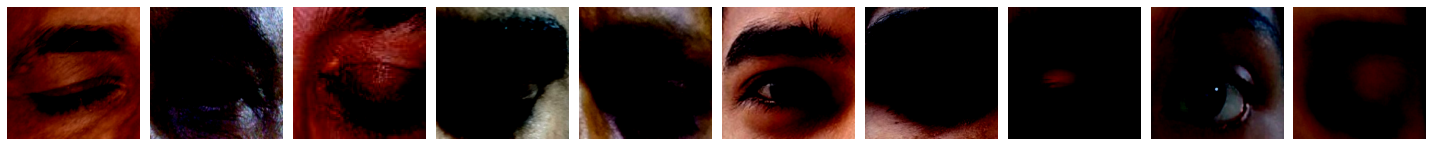

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [8]:
# a = plt.imread("/content/drive/MyDrive/CP/data/train/Closed/_5.jpg").shape
# print(a)
assert train_generator.n == 1012
assert valid_generator.n == 200
assert test_generator.n == 240
imgs, labels = next(train_generator)
def plotImages (images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
    ax. imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)
print(labels)

# **CNN MODEL**


In [19]:
model_cnn = Sequential([
                   Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
                   MaxPool2D(pool_size=(2, 2), strides=2),
                   Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size=(2, 2), strides=2),
                   Flatten(),
                   Dense(units=2, activation='softmax'),
])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [20]:
model_cnn.compile(optimizer='adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])

In [21]:
model_cnn.fit(x=train_generator, validation_data=valid_generator, epochs = 20, verbose=2, shuffle=True)

Epoch 1/20
102/102 - 89s - loss: 0.4111 - accuracy: 0.8389 - val_loss: 0.1734 - val_accuracy: 0.9200
Epoch 2/20
102/102 - 70s - loss: 0.2063 - accuracy: 0.9289 - val_loss: 0.1919 - val_accuracy: 0.9350
Epoch 3/20
102/102 - 70s - loss: 0.1606 - accuracy: 0.9437 - val_loss: 0.2024 - val_accuracy: 0.9400
Epoch 4/20
102/102 - 70s - loss: 0.1254 - accuracy: 0.9555 - val_loss: 0.5479 - val_accuracy: 0.8800
Epoch 5/20
102/102 - 70s - loss: 0.1258 - accuracy: 0.9565 - val_loss: 0.1167 - val_accuracy: 0.9450
Epoch 6/20
102/102 - 70s - loss: 0.0575 - accuracy: 0.9783 - val_loss: 0.2186 - val_accuracy: 0.9350
Epoch 7/20
102/102 - 70s - loss: 0.0516 - accuracy: 0.9852 - val_loss: 0.2113 - val_accuracy: 0.9450
Epoch 8/20
102/102 - 69s - loss: 0.1057 - accuracy: 0.9664 - val_loss: 0.3504 - val_accuracy: 0.9350
Epoch 9/20
102/102 - 70s - loss: 0.0779 - accuracy: 0.9723 - val_loss: 0.2361 - val_accuracy: 0.9550
Epoch 10/20
102/102 - 69s - loss: 0.0333 - accuracy: 0.9881 - val_loss: 0.2344 - val_accura

In [22]:
model_cnn.save(root_path+'models/model_cnn.h5')
json_out = open(root_path+"models/model_cnn.json", "w")   
json.dump(model_cnn.to_json(), json_out, indent = 6) 
json_out.close() 

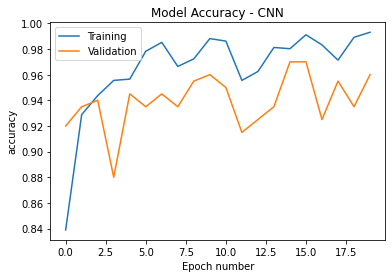

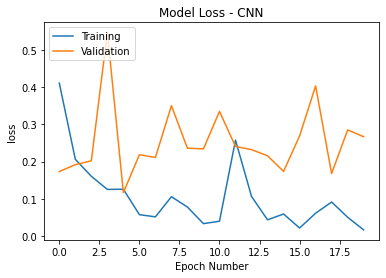

<Figure size 432x288 with 0 Axes>

In [23]:
hist = model_cnn.history

# Accuracy visualize
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy - CNN')
plt.ylabel('accuracy')
plt.xlabel('Epoch number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Accuracy - CNN.png')

# Loss visualize
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss - CNN')
plt.ylabel('loss')
plt.xlabel('Epoch Number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Loss - CNN.png')

# **VGG16 Model**

In [9]:
vgg = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [10]:
train_generator1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=path_train,target_size= (224,224), classes=['Closed', 'Open'],batch_size=5)
valid_generator1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=path_valid,target_size= (224,224), classes=['Closed', 'Open'],batch_size=5)
test_generator1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=path_test,target_size= (224,224), classes=['Closed', 'Open'],batch_size=5, shuffle=False)

Found 1012 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [11]:
# vgg.summary()
model_vgg = Sequential()
for layer in vgg.layers:
  model_vgg.add(layer)
model_vgg.layers.pop()
for layer in model_vgg.layers:
    layer.trainable = False
model_vgg.add(Dense(2, activation='softmax'))
# model_vgg.summary()
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
model_vgg.fit(train_generator1, steps_per_epoch=4, validation_data=valid_generator1, validation_steps=4, epochs=20, verbose=2)

Epoch 1/20
4/4 - 24s - loss: 0.6701 - accuracy: 0.5882 - val_loss: 0.6224 - val_accuracy: 0.7000
Epoch 2/20
4/4 - 25s - loss: 0.6234 - accuracy: 0.6500 - val_loss: 0.6749 - val_accuracy: 0.5500
Epoch 3/20
4/4 - 24s - loss: 0.7392 - accuracy: 0.5000 - val_loss: 0.7099 - val_accuracy: 0.5000
Epoch 4/20
4/4 - 23s - loss: 0.6751 - accuracy: 0.6000 - val_loss: 0.6322 - val_accuracy: 0.7000
Epoch 5/20
4/4 - 23s - loss: 0.6396 - accuracy: 0.7000 - val_loss: 0.5796 - val_accuracy: 0.9500
Epoch 6/20
4/4 - 23s - loss: 0.6202 - accuracy: 0.8000 - val_loss: 0.6166 - val_accuracy: 0.7500
Epoch 7/20
4/4 - 23s - loss: 0.5607 - accuracy: 0.9000 - val_loss: 0.5892 - val_accuracy: 0.9000
Epoch 8/20
4/4 - 22s - loss: 0.5625 - accuracy: 0.8000 - val_loss: 0.5746 - val_accuracy: 0.8000
Epoch 9/20
4/4 - 23s - loss: 0.5916 - accuracy: 0.7500 - val_loss: 0.4921 - val_accuracy: 0.8500
Epoch 10/20
4/4 - 23s - loss: 0.5165 - accuracy: 0.8500 - val_loss: 0.5801 - val_accuracy: 0.8000
Epoch 11/20
4/4 - 22s - loss:

In [12]:
model_vgg.save(root_path+'models/model_vgg.h5')
json_out = open(root_path+"models/model_vgg.json", "w")   
json.dump(model_vgg.to_json(), json_out, indent = 6) 
json_out.close()

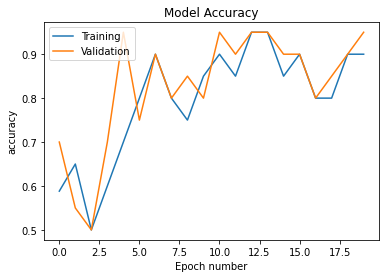

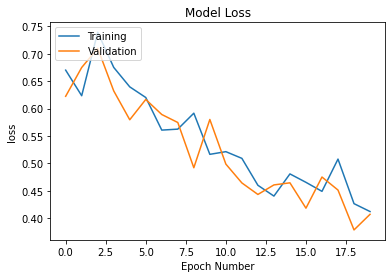

<Figure size 432x288 with 0 Axes>

In [13]:
hist = model_vgg.history

# Accuracy visualize
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Accuracy - VGG.png')

# Loss visualize
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch Number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Loss - VGG.png')

In [ ]:
prediction = model_vgg.predict_classes(test_generator1)

NameError: ignored

# **MobileNet Model**

In [14]:
mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [15]:
# mobile.summary()
model_mobile = Sequential()
for layer in mobile.layers:
  model_mobile.add(layer)
model_mobile.layers.pop()
for layer in model_mobile.layers:
    layer.trainable = False
model_mobile.add(Dense(2, activation='softmax'))
# model_vgg.summary()
model_mobile.compile(optimizer='adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
model_mobile.fit(train_generator, steps_per_epoch=4, validation_data=valid_generator, validation_steps=4, epochs=20, verbose=2)

Epoch 1/20
4/4 - 10s - loss: 0.6954 - accuracy: 0.5250 - val_loss: 0.6910 - val_accuracy: 0.6500
Epoch 2/20
4/4 - 9s - loss: 0.6916 - accuracy: 0.5250 - val_loss: 0.6936 - val_accuracy: 0.5250
Epoch 3/20
4/4 - 10s - loss: 0.6945 - accuracy: 0.4500 - val_loss: 0.6897 - val_accuracy: 0.6000
Epoch 4/20
4/4 - 8s - loss: 0.6892 - accuracy: 0.5500 - val_loss: 0.6900 - val_accuracy: 0.5500
Epoch 5/20
4/4 - 8s - loss: 0.6918 - accuracy: 0.5250 - val_loss: 0.6906 - val_accuracy: 0.6000
Epoch 6/20
4/4 - 7s - loss: 0.6810 - accuracy: 0.7500 - val_loss: 0.6860 - val_accuracy: 0.6750
Epoch 7/20
4/4 - 6s - loss: 0.6877 - accuracy: 0.6250 - val_loss: 0.6814 - val_accuracy: 0.7250
Epoch 8/20
4/4 - 6s - loss: 0.6893 - accuracy: 0.6500 - val_loss: 0.6840 - val_accuracy: 0.6750
Epoch 9/20
4/4 - 6s - loss: 0.6814 - accuracy: 0.6500 - val_loss: 0.6798 - val_accuracy: 0.7500
Epoch 10/20
4/4 - 6s - loss: 0.6793 - accuracy: 0.7750 - val_loss: 0.6817 - val_accuracy: 0.7500
Epoch 11/20
4/4 - 7s - loss: 0.6797 -

In [16]:
model_mobile.save(root_path+'models/model_mobile.h5')
json_out = open(root_path+"models/model_mobile.json", "w")   
json.dump(model_mobile.to_json(), json_out, indent = 6) 
json_out.close()

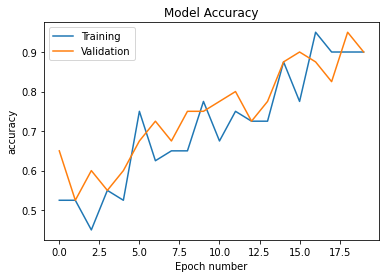

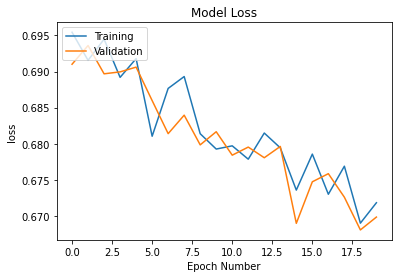

<Figure size 432x288 with 0 Axes>

In [17]:
hist = model_mobile.history

# Accuracy visualize
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Accuracy - MOBILENET.png')

# Loss visualize
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch Number')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Model Loss - MOBILENET.png')

# **Compare the Models**

get all the accuracies

In [24]:
model_cnn_acc = np.array(model_cnn.history.history['accuracy'])
model_vgg_acc = np.array(model_vgg.history.history['accuracy'])
model_mobile_acc = np.array(model_mobile.history.history['accuracy'])

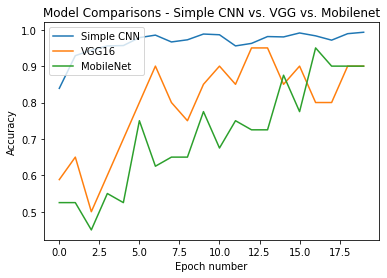

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(model_cnn_acc)
plt.plot(model_vgg_acc)
plt.plot(model_mobile_acc)
plt.title('Model Comparisons - Simple CNN vs. VGG vs. Mobilenet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Simple CNN', 'VGG16', 'MobileNet'], loc='upper left')
plt.show()
plt.savefig('Model Comparisons.png')

# **Confusion Matrix**

use this function to plot confusion matrix to judge the performance of model over the test set.

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
# predictions = model_cnn.predict(x=test_generator, verbose=2)
# cm = plot_confusion_matrix(test_generator, predictions[:,0])
# cm_plot_labels = ['Closed','Open']
# plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')